<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 &ndash; Your First Neural Networks</h2>

<b>Authors:</b> Brandstetter, Schäfl, Schlüter, Schörgenhumer<br>
<b>Date:</b> 05-12-2022

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.

New packages compared to the last lectures are <code>tqdm</code> and <code>ipywidgets</code> (https://ipywidgets.readthedocs.io/en/latest/user_install.html) for progress bars.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u5_utils as u5

# Import additional utilities needed in this notebook.
import numpy as np
import seaborn as sns
import torch

from scipy.special import expit as sigmoid

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [2]:
u5.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.21.5 (✓)
Installed pandas version: 1.4.2 (✓)
Installed scikit-learn version: 1.0.2 (✓)
Installed matplotlib version: 3.5.1 (✓)
Installed seaborn version: 0.11.2 (✓)
Installed scipy version: 1.7.3 (✓)
Installed torch version: 1.13.0 (✓)
Installed tqdm version: 4.64.0 (✓)


<h3 style="color:rgb(0,120,170)">Outline</h3>

Today we will create our first neural networks. Before we can do that, we will revisit the difference between <b>convex loss functions</b> and <b>non-convex loss functions</b>, and see how to <b>optimize parameters</b> in the non-convex case &ndash; this is what we need to deal with for our neural networks.

<h1 style="color:rgb(0,120,170)">A convex loss function: Linear regression</h1>

<h2 style="color:rgb(0,120,170)">Dataset</h2>

Remember the linear regression example from the last lecture. We started out with a dataset $S$ of two variables, $x$ and $y$ (often termed <i>feature</i> and <i>target</i>):

$$S = \{(x_i, y_i)\}_{i=1}^{n}\quad{}\text{with}\quad{}x, y\in{}\mathbb{R}^1$$

We created this dataset by sampling values for $x$ and computing $y = 0.241 + 0.422 \cdot x$, then adding some noise to $y$.

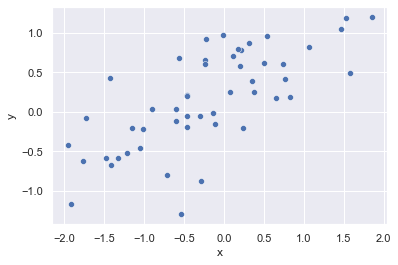

In [3]:
# Set seed for reproducibility.
u5.set_seed(seed=42)

# Create dataset consisting of random (x, y) pairs.
dataset = u5.get_dataset(
    num_pairs=50,  # number of data points to create
    coefficients=(0.241, 0.422),  # coefficients for computing y from x
    variance=0.5  # variance of the noise of the observations
)

# Display the dataset.
sns.scatterplot(data=dataset, x="x", y="y");

<h2 style="color:rgb(0,120,170)">Model</h2>

We can try to approximate the relation between $x$ and $y$ using a simple <i>linear</i> model (a polynomial of degree 1):

$$g(x; w) = g(x; d, k) = d \cdot x^0 + k \cdot x^1 = d + k \cdot x$$

In [4]:
def model(x, d, k):
    return d + k * x

<h2 style="color:rgb(0,120,170)">Loss function</h2>

We measure the quality of our approximation using a <b>loss function</b>. For linear regression, the loss function of choice is the <b>Mean Squared Error (MSE)</b>:

$$MSE = \frac{1}{n}\sum_{i=0}^{n}{\left(y_i - g(x_i; d, k)\right)^2} = \frac{1}{n}\sum_{i=0}^{n}{\left(y_i - g(x_i; w)\right)^2}$$

It compares the predictions of the model with the targets from the dataset, by computing the squared difference averaged over all data points. We can regard it as a function that depends on the dataset $S$ and the model parameters $d, k$.

In [5]:
def loss(dataset, d, k):
    predictions = model(dataset.x.values, d, k)
    targets = dataset.y.values
    return np.mean((targets - predictions) ** 2, axis=-1)  # axis=-1 needed when passing multi-dimensional d,k

Our goal will be to find model parameters $d, k$ which minimize this loss function for our dataset. Since this is a small dataset and a simple model, we can visualize what the loss landscape looks like, by probing it for different combinations of $d$ and $k$!

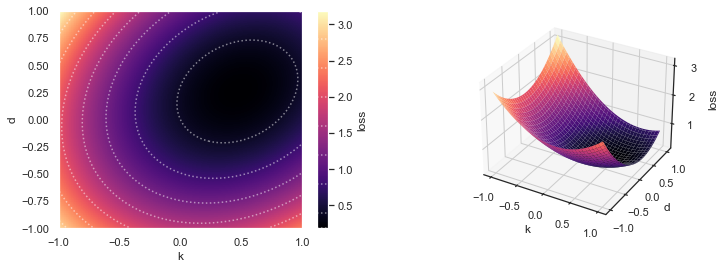

In [6]:
d_values = np.linspace(-1, 1, 101)
k_values = np.linspace(-1, 1, 101)
landscape = u5.plot_loss_landscape(loss, dataset, d=d_values, k=k_values)

This looks like a convex function: We only see a single minimum.

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>Check whether you can find a second minimum by extending the range of d and k.</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Optimization: The dumb way</h2>

From the plot, we see that the minimum is around $d=0.25, k=0.5$. Since we already computed the loss for different combinations of $d$ and $k$, we can just search for the arguments of the minimum value in the plot:

In [7]:
d, k = landscape.stack().idxmin()  # return row and column of the minimum value
print(d, k)

0.26 0.48


The corresponding loss value is:

In [8]:
loss(dataset, d, k)

0.18506415546699442

And our regression line looks like this:

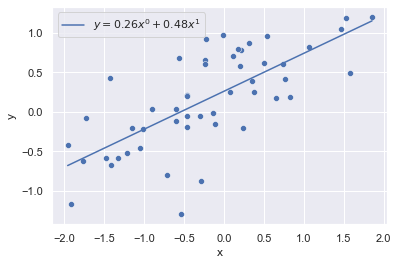

In [9]:
u5.plot_model(dataset, (d, k))

What we did here is called a <b>grid search</b>: We set up a range of values for each parameter and then searched for the best combination by blindly trying all of them. This is the least smart way to optimize a function. It worked because we only had two free parameters, the function is cheap to compute, and we were lucky that the optimum was within our search range. We only know two decimal digits of the optimum, though, we would need to refine the search range to get closer.

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>Refine the search range to get closer to the optimum and find a loss below 0.18502.</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Optimization: The elegant way</h2>

Let's look at the loss landscape again:

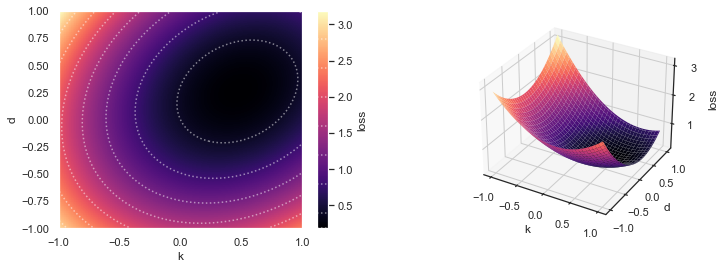

In [10]:
d_values = np.linspace(-1, 1, 101)
k_values = np.linspace(-1, 1, 101)
landscape = u5.plot_loss_landscape(loss, dataset, d=d_values, k=k_values)

It looks suspiciously like a stretched 3-dimensional parabola, an <i>elliptic paraboloid</i>, a squared function of $d$ and $k$. If so, it must take the following form:

$$MSE = a_1 \cdot d^2 + a_2 \cdot k^2 + a_3 \cdot d \cdot k + a_4 \cdot d + a_5 \cdot k + a_6$$

Let's see if we can arrive at this form by starting from the definitions of MSE and our model and applying some high-school math:

\begin{align*}
MSE
&= \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - g(x_i; d, k)\right)^2} \\
&= \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - d - k \cdot x_i\right)^2} \\
&= \frac{1}{n}\sum_{i=1}^{n}{y_i^2 -2 y_i d - 2 y_i k x_i -d^2 -2 d k x_i - k^2 x_i^2} \\
&= -1 \cdot d^2 - \left(\frac{1}{n}\sum_{i=1}^{n}{x_i^2}\right) \cdot k^2 - \left(\frac{1}{n}\sum_{i=1}^{n}{2 x_i}\right) \cdot d \cdot k - \left(\frac{1}{n}\sum_{i=1}^{n}{2 y_i}\right) \cdot d - \left(\frac{1}{n}\sum_{i=1}^{n}{2 y_i x_i}\right) \cdot k - \left(\frac{1}{n}\sum_{i=1}^{n}{y_i^2}\right)
\end{align*}

That was easy enough. We can directly compute the coefficients $a_i$ from the dataset! For quadratic functions, the minimum can be computed <i>analytically</i>, i.e., [there are equations](https://calculus.subwiki.org/wiki/Quadratic_function_of_multiple_variables) we can plug in our coefficients to obtain the coordinates of the minimum. Since curve fitting is a commonly required operation, all these steps are also provided by a single numpy function:

In [11]:
d, k = np.polyfit(x=dataset.x, y=dataset.y, deg=1)[::-1]  # [::-1] is only done for consistency, since np.polyfit returns the coefficients starting with the highest power first
print(d, k)

0.2615108693933983 0.47353782273040046


In [12]:
loss(dataset, d, k)

0.18501967145536963

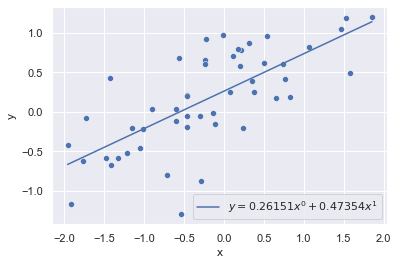

In [13]:
u5.plot_model(dataset, (d, k))

<h1 style="color:rgb(0,120,170)">A convex loss function without closed-form solution: Logistic regression</h1>

<h2 style="color:rgb(0,120,170)">Dataset</h2>

We will reuse the logistic regression dataset from the last lecture. The dataset had two variables, $x$ and $y$ (termed <i>feature</i> and <i>label/class</i>):

$$S = \{(x_i, y_i)\}_{i=1}^{n}\quad{}\text{with}\quad{}x\in{}\mathbb{R}^1,\;y\in{}\{0,1\}$$

We created this dataset by sampling values for $x$ and setting $y = 1$ for $x > 0.5$ and $y = 0$ otherwise.

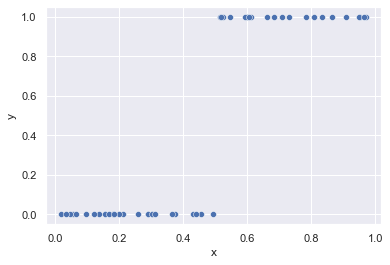

In [14]:
# Set seed for reproducibility.
u5.set_seed(seed=42)

# Create dataset consisting of random (x, y) pairs.
dataset = u5.get_dataset_logistic(
    num_pairs=50,   # number of data points
    threshold=0.5,  # position of class boundary
    variance=0.0    # amount of noise
)

# Display the dataset.
sns.scatterplot(data=dataset, x="x", y="y");

<h2 style="color:rgb(0,120,170)">Model</h2>

We already saw that a linear model is not suitable and used a <i>logistic</i> model instead:

$$g(x; w) = g(x; d, k) = \sigma\left(d \cdot x^0 + k \cdot x^1\right) = \sigma\left(d + k \cdot x\right)$$

Here, $\sigma(a) = \dfrac{1}{1 + \exp(-a)}$ is the <i>logistic function</i> or <i>sigmoid function</i>.

In [15]:
def model(x, d, k):
    # Use existing implementation of the sigmoid function (imported in the beginning: scipy.special.expit = sigmoid)
    return sigmoid(d + k * x)

<h2 style="color:rgb(0,120,170)">Loss function</h2>

The <b>loss function</b> for logistic regression is the <b>Binary Cross-Entropy (BCE)</b>:

$$BCE = \frac{1}{n}\sum_{i=1}^{n}{\left(-y_i \log(g(x_i; d, k)) -(1 - y_i) \log(1 - g(x_i; d, k)\right)}$$

It is not important to understand the formula, just rest assured that it can be derived from similar principles as the mean-squared error (maximum likelihood estimation). Again, we can regard it as a function that depends on the dataset $S$ and the model parameters $d, k$.

In [16]:
def loss(dataset, d, k):
    predictions = model(dataset.x.values, d, k)
    targets = dataset.y.values
    return np.mean(-targets * np.log(predictions) - (1 - targets) * np.log(1 - predictions), axis=-1)

Again, we are in the lucky position that we can probe the loss function to visualize the loss landscape:

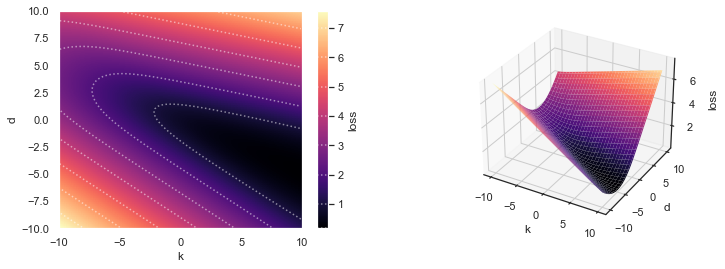

In [17]:
d_values = np.linspace(-10, 10, 101)
k_values = np.linspace(-10, 10, 101)
landscape = u5.plot_loss_landscape(loss, dataset, d=d_values, k=k_values)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Extend the range of $d$ and $k$. Can you find a minimum?</li>
        <li>Go back to the dataset definition and move the classification boundary or add noise. Can you find a minimum now?
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Optimization: The dumb way</h2>

Again, we can pick the minimum value from the plot:

In [18]:
d, k = landscape.stack().idxmin()  # return row and column of the minimum value
print(d, k)

-4.8 10.0


The corresponding loss value is:

In [19]:
loss(dataset, d, k)

0.16440766

And our predictions look like this:

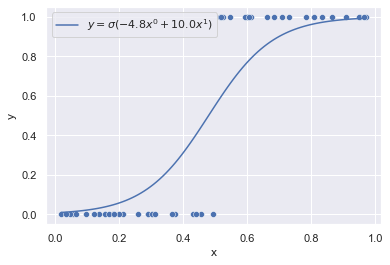

In [20]:
u5.plot_model(dataset, (d, k), transform=sigmoid)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Can you improve the loss by extending the search range?</li>
        <li>Can you pick better values by hand?
    </ul>
</div>

<h3 style="color:#9C477B">Info</h3>

<div class="alert alert-warning">When you extend the search range, you may get a &quot;<b>RuntimeWarning: divide by zero encountered in log</b>&quot;. For large values of $d$ and $k$, the sigmoid in the model will squash the output to exactly 0.0 or 1.0, and then one of the two logarithms is undefined. We can avoid this by incorporating the sigmoid in the loss function and <a href="https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits">applying some calculus</a>. Execute the following cell to replace the loss function and try again.</div>

In [21]:
def loss(dataset, d, k):
    predictions_before_sigmoid = d + k * dataset.x.values  # the unscaled output, also called "logits"
    targets = dataset.y.values
    return np.mean(np.maximum(predictions_before_sigmoid, 0)
                   - targets * predictions_before_sigmoid
                   + np.log1p(np.exp(-abs(predictions_before_sigmoid))),
                   axis=-1)

<h2 style="color:rgb(0,120,170)">Optimization: The elegant way</h2>

Sorry to disappoint you: We cannot play a similar trick as for linear regression. There is no closed-form solution for the minimum that we can compute from the dataset. In fact, for unregularized logistic regression, there is no minimum at all!

<h2 style="color:rgb(0,120,170)">Optimization: The general way</h2>

Grid search is only applicable to small problems, a closed-form solution does not exist, what now? There is some other information we can exploit, which is the <b>gradient of the loss function</b>. The gradient is another function of $d$ and $k$ which tells us the <b>slope</b> of the loss function at a particular position. It can be computed analytically or numerically, we just need to take care that the function is <b>differentiable</b>. For logistic regression with binary cross-entropy, it takes a very simple form:

In [22]:
def loss_grad(dataset, d, k):
    predictions = model(dataset.x.values, d, k)
    targets = dataset.y.values
    delta = predictions - targets
    d_grad = np.mean(delta, axis=-1)
    k_grad = np.mean(dataset.x.values * delta, axis=-1)
    return d_grad, k_grad

We can visualize it in the form of arrows overlaid on the loss surface:

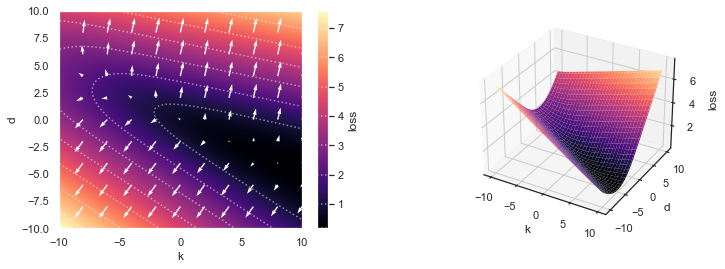

In [23]:
d_values = np.linspace(-10, 10, 101)
k_values = np.linspace(-10, 10, 101)
landscape = u5.plot_loss_landscape(loss, dataset, d=d_values, k=k_values, grad_fn=loss_grad)

At each position ($d$, $k$), the gradient gives the direction of steepest ascent. If we start from a random position and take a small step in the <i>opposite direction</i> of the gradient, we will end up at a lower loss!

<b>Gradient Descent</b> is an algorithm exploiting exactly this principle: It starts at a random position and repeatedly takes small steps in the direction opposing the gradient. It is easy to implement:

In [24]:
def gradient_descent(grad_fn, dataset, d, k, steps, stepsize):
    for _ in range(steps):
        d_grad, k_grad = grad_fn(dataset, d, k)
        d = d - stepsize * d_grad
        k = k - stepsize * k_grad
    return d, k

Note that this only requires a single evaluation of the gradient function per step. The algorithm does not "see" anything but the slope at the current $d$ and $k$ and follows it. It does not even regard the loss or compute the loss landscape. Let's try it:

In [25]:
d, k = 7.5, -6  # starting point
steps = 1000    # number of updates
stepsize = 0.1  # size of updates ("learning rate")
print(f"Initial: d={d:9f}, k={k:9f}, loss={loss(dataset, d, k):9f}")
d, k = gradient_descent(loss_grad, dataset, d, k, steps, stepsize)
print(f"Final:   d={d:9f}, k={k:9f}, loss={loss(dataset, d, k):9f}")

Initial: d= 7.500000, k=-6.000000, loss= 3.466320
Final:   d=-1.620399, k= 3.289147, loss= 0.387392


Seems to work, we reduced the loss! For further experimentation, we provide an implementation that also includes a visualization of the trajectory taken through the loss landscape:

Final: d=-1.621829, k= 3.292104, loss= 0.387203


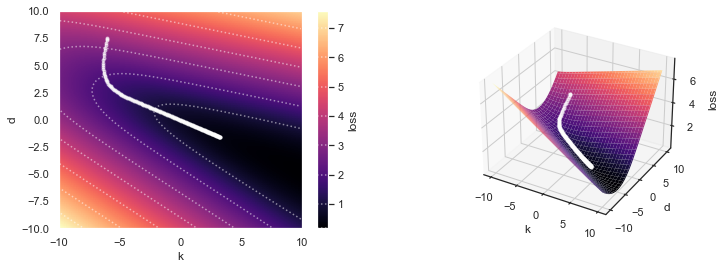

In [26]:
d, k = u5.plot_gradient_descent(
    loss, loss_grad, dataset,
    d=7.5, k=-6,   # starting position
    steps=1000,    # number of updates
    stepsize=0.1,  # learning rate
    momentum=0.9   # momentum term (between 0 and 1)
)
print(f"Final: d={d:9f}, k={k:9f}, loss={loss(dataset, d, k):9f}")

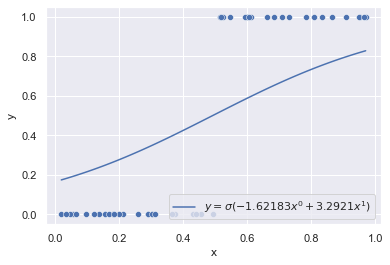

In [27]:
u5.plot_model(dataset, (d, k), transform=sigmoid)

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>What happens if you change the number of iterations and the learning rate?</li>
        <li>What happens if you set the learning rate too high?</li>
        <li>What happens if you set momentum to 0.9 at a high learning rate?</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">Moving to PyTorch</h1>

You should now have a fairly good intuition on how loss functions and optimization work. As a basis for the first deep neural network, let's quickly reimplement the last experiment in PyTorch.

We'll start with defining the model:

In [28]:
u5.set_seed(42)
model = torch.nn.Linear(1, 1)

Yes, that's it. A linear transformation with 1 input ($x$) and 1 output ($y$). We omit the sigmoid, because as we already saw above, it's better to integrate it with the loss. We can already pass data through the model:

In [29]:
rnd_data = torch.randn(3, 1)  # 3 random data points of 1 feature
model(rnd_data)

tensor([[1.1924],
        [0.9812],
        [1.7139]], grad_fn=<AddmmBackward0>)

PyTorch records the operation resulting in this tensor ("grad_fn") so that it can compute gradients later. Note that we did not have to pass $d$ and $k$, only the data. The model stores its parameters internally (which makes it much easier to replace a model by another):

In [30]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[0.7645]], requires_grad=True)
Parameter containing:
tensor([0.8300], requires_grad=True)


They were initialized randomly when we created the model. This corresponds to our starting position for $k$ and $d$. Let us define the loss:

In [31]:
loss = torch.nn.functional.binary_cross_entropy_with_logits

It's a predefined function in PyTorch which combines the sigmoid and binary cross-entropy, similar to our implementation of "loss()" further above.

Finally, let's instantiate an optimizer that does Gradient Descent:

In [32]:
optimizer = torch.optim.SGD(
    model.parameters(),  # the model parameters to train
    lr=0.1,              # the step size/learning rate
    momentum=0.0,        # and the momentum
)

And run some optimization steps for our dataset (feel free to run it multiple times, it will continue where it left off):

In [3]:
# Data points must be in "row-format" (see example "rnd_data" above) in order for our PyTorch model to work
X = torch.as_tensor(dataset[["x"]].values)
Y = torch.as_tensor(dataset[["y"]].values)

d, k = model.bias.item(), model.weight.item(),  model.weight.item()
error = loss(model(X), Y)
print(f"Initial: d={d:9f}, k={k:9f}, loss={error.item():9f}")

for _ in range(1000):  # number of updates
    preds = model(X)        # compute predictions
    error = loss(preds, Y)  # compute error
    error.backward()        # compute gradient of the error
    optimizer.step()        # perform update step
    optimizer.zero_grad()   # reset gradients for the next iteration

d, k = model.bias.item(), model.weight.item()
print(f"Final:   d={d:9f}, k={k:9f}, loss={error.item():9f}")
u5.plot_model(dataset, (d, k), transform=sigmoid)

NameError: name 'torch' is not defined

Did you notice that we did not define a function computing the gradient of the loss? This is a <b>key benefit</b> of deep learning frameworks: They provide <b>building blocks</b> to plug together a model and a loss function, and since each building block knows how to compute its gradient, the framework can easily <b>compute the gradient</b> for however we combined the blocks <b>automatically</b>.

<h3 style="color:rgb(0,120,170)">Task</h3>
<div class="alert alert-warning">
    <ul>
        <li>Try different values for the random seed used when creating the model. How much does it influence the error obtained after training?</li>
    </ul>
</div>

<h1 style="color:rgb(0,120,170)">Moving to MNIST</h1>

We will now change the task and go for handwritten digit recognition using the [MNIST database (Modified National Institute of Standards and Technology database)](http://yann.lecun.com/exdb/mnist/) again.

<h2 style="color:rgb(0,120,170)">Preparation</h2>

<div class="alert alert-warning">
    <b>Hint:</b> If you copy the corresponding data folder from the last lecture or exercise, or adapt the root path given here, it will not have to download the dataset again.
</div>

In [34]:
train_loader, test_loader = u5.get_dataset_mnist(root="resources")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\train-images-idx3-ubyte.gz to resources\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\train-labels-idx1-ubyte.gz to resources\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\t10k-images-idx3-ubyte.gz to resources\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting resources\MNIST\raw\t10k-labels-idx1-ubyte.gz to resources\MNIST\raw



As you may remember, it has inputs of $28 \times 28 = 784$ pixels, and $10$ classes. We redefine our model accordingly:

In [35]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 10)
)

It now consists of two building blocks executed after each other: The first one converts the image from its 2-dimensional shape to a vector (`Flatten()`). The second one projects the $784$-dimensional inputs to $10$-dimensional outputs. These will be transformed to probabilities for the $10$ classes using the softmax function introduced last time. But again, we do not include it in the model, as it is numerically benefitial to include it in the loss. Let's define it:

In [36]:
loss = torch.nn.functional.cross_entropy

<h2 style="color:rgb(0,120,170)">Interlude: Plotting the loss landscape</h2>

Now you may wonder what the <b>loss landscape</b> looks like. Can we plot it? Further above, we computed it by probing the loss function with our 50-example dataset and different combinations of the two model parameters $d$ and $k$. Let's briefly check what's the size of our dataset now:

In [37]:
len(train_loader.dataset)

60000

Much larger, but we could just use a subset to get an idea. Let's check how many parameters we have:

In [38]:
for p in model.parameters():
    print(p.shape)
print("Total count:", sum(np.prod(p.shape) for p in model.parameters()))

torch.Size([10, 784])
torch.Size([10])
Total count: 7850


Uh. Let's say we try 10 different values for each parameter, then we'll need to probe the loss function $10^{7850}$ times. (Just to put this into perspective, the universe is estimated to consist of about $10^{80}$ particles.) Afterwards we'd need to visualize the result in a $7850$-dimensional plot. Maybe not...

This is why grid search is not suitable in high dimensions. Gradient Descent is still fine! We can compute the gradient of a point in the $7850$-dimensional loss landscape and take a small step in the opposite direction. This is what we'll do now.

<h2 style="color:rgb(0,120,170)">Training the model</h2>

We wrapped the remaining parts (instantiating the optimizer and running the training loop) in a utility function for you. Let's run it:

In [39]:
# Set seed for reproducibility.
u5.set_seed(seed=42)

# Create model here again to ensure that the random parameter initialization is reproducible.
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 10)
)

# Minimize the given loss for the given model.
losses = u5.run_gradient_descent(
    model=model,
    loss=loss,
    training_set=train_loader,
    iterations=5,        # number of iterations/epochs over the training set
    learning_rate=0.01,  # step size/learning rate
    momentum=0.9         # momentum
)

  0%|          | 0/60000 [00:00<?, ?it/s]

Epoch  1 finished with training loss: 0.484280
Epoch  2 finished with training loss: 0.436837
Epoch  3 finished with training loss: 0.428990
Epoch  4 finished with training loss: 0.424199
Epoch  5 finished with training loss: 0.417128


It returns the <i>training curve</i>, the loss on the training set after each epoch (Info: Within each epoch, the loss is computed for each data batch returned by the data loader (see `u5.get_dataset_mnist` for changing the default batch size of 20), and the model is updated afterwards. After all batches, the loss is then calculated as the average of all batch-losses):

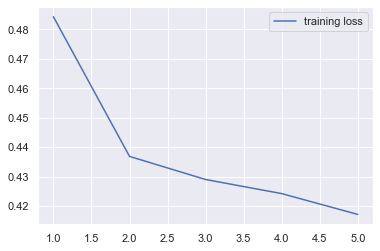

In [40]:
sns.lineplot(data=losses);

Ideally, it should smoothly go downwards. If you set the learning rate too high, it will zigzag a lot or even go up. If you set it too low, it will be mostly horizontal.

To check how well our model performs, we can compute its loss and classification accuracy on the training and test set:

In [41]:
print("Training set:")
print(u5.evaluate_model(model, train_loader, loss=loss, accuracy=u5.multiclass_accuracy))
print("Test set:")
print(u5.evaluate_model(model, test_loader, loss=loss, accuracy=u5.multiclass_accuracy))

Training set:
{'loss': 0.4042581358831376, 'accuracy': 0.906266661286354}
Test set:
{'loss': 0.45931543613248504, 'accuracy': 0.8985999977588653}


The loss corresponds to the loss we minimized during training. The classification accuracy is expressed as a number between 0.0 and 1.0; multiply it by 100 in your head to get a percentage.

<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Can you set the learning rate so high that the error goes up instead of down?</li>
        <li>Can you set the learning rate so low that you get a training accuracy below 30%?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Moving to Neural Networks</h2>

Finally, let us replace the Logistic Regression model by a neural network! Let's recap how we defined our model:

In [42]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 10)
)

We can visualize it as a set of ~~784~~ 25 input nodes (784 would just be too many) directly connected to 10 output nodes.

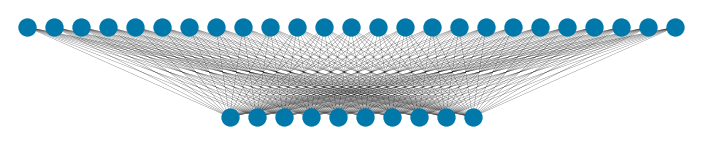

In [43]:
u5.visualize_model((25, 10))

All we need to do is to add another layer:

In [44]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 20),
    torch.nn.Linear(20, 10)
)

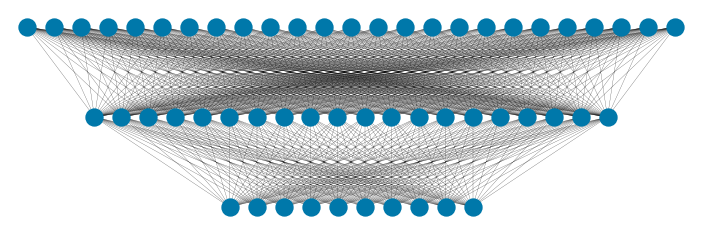

In [45]:
u5.visualize_model((25, 20, 10))

Or is it? If we put <b>two linear transformations</b> from 784 to 20 and 20 to 10 dimensions <b>in a row</b>, they can be collapsed into a <b>single linear transformation</b> from 784 to 10 dimensions again! We need to add a <b>nonlinear operation</b> in between:

In [46]:
# Set seed for reproducibility.
u5.set_seed(seed=42)

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 20),  # hidden layer
    torch.nn.Sigmoid(),        # nonlinearity
    torch.nn.Linear(20, 10)    # output layer
)

Finally, we can train the model and see what we get (regarding the "validation" set, see description further below):

In [47]:
# Reload dataset with custom batch size and 10% of examples as a validation set.
train_loader, valid_loader, test_loader = u5.get_dataset_mnist(root="resources", batch_size=20, valid_size=0.1)

# Minimize the given loss for the given model.
losses = u5.run_gradient_descent(
    model=model,
    loss=loss,
    training_set=train_loader,
    valid_set=valid_loader,
    iterations=5,        # number of iterations/epochs over the training set
    learning_rate=0.01,  # step size/learning rate
    momentum=0.9         # momentum
)

  0%|          | 0/54000 [00:00<?, ?it/s]

Epoch  1 finished with training loss: 0.438501 and validation loss: 0.266388
Epoch  2 finished with training loss: 0.235530 and validation loss: 0.229925
Epoch  3 finished with training loss: 0.203799 and validation loss: 0.220369
Epoch  4 finished with training loss: 0.186218 and validation loss: 0.197671
Epoch  5 finished with training loss: 0.173964 and validation loss: 0.197565


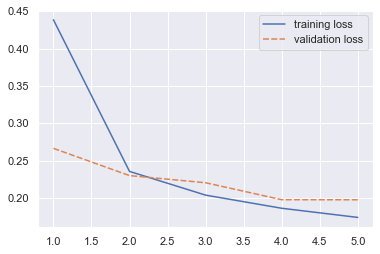

In [48]:
sns.lineplot(data=losses);

Note that compared to before, we are reserving a fraction of the training data for <b>validation</b> &ndash; something like a mini test set to monitor if we are overfitting. This is what we used to compute the "validation loss". If the training loss goes down, but the validation loss goes up, the model is overfitting the training data.

In [49]:
print("Training set:")
print(u5.evaluate_model(model, train_loader, loss=loss, accuracy=u5.multiclass_accuracy))
print("Test set:")
print(u5.evaluate_model(model, test_loader, loss=loss, accuracy=u5.multiclass_accuracy))

Training set:
{'loss': 0.16195163484904226, 'accuracy': 0.9537777702675926}
Test set:
{'loss': 0.19325466662459076, 'accuracy': 0.9429999945163727}


<h3 style="color:rgb(0,120,170)">Tasks</h3>
<div class="alert alert-warning">
    <ul>
        <li>Improve the scores! Can you reach a training accuracy of at least 98%? A test accuracy of at least 97%?</li>
        <li>Aspects to vary:
            <ul>
                <li>Training parameters: batch size, iterations, learning rate, momentum</li>
                <li>size (number of nodes) of hidden layer</li>
                <li>number of layers (do not forget the nonlinearities!)</li>
                <li>type of nonlinearity (Sigmoid(), Tanh(), ReLU(), ELU(), ...)</li>
            </ul>
        </li>
        <li>Can you get the model to overfit? I.e., obtaining a better training error but a worse test error?</li>
    </ul>
</div>

<h2 style="color:rgb(0,120,170)">Bonus: What features did the model learn?</h2>

The weights of the first layer form a matrix of $n \times 784$, where $784$ is the number of input pixels and $n$ is the number of nodes. We can take any row of the matrix, a $784$-dimensional vector, reshape it to $28 \times 28$, the shape of the MNIST images, and plot it to see what the corresponding node learned. We provide a function that plots several of the weights into a single grid of images:

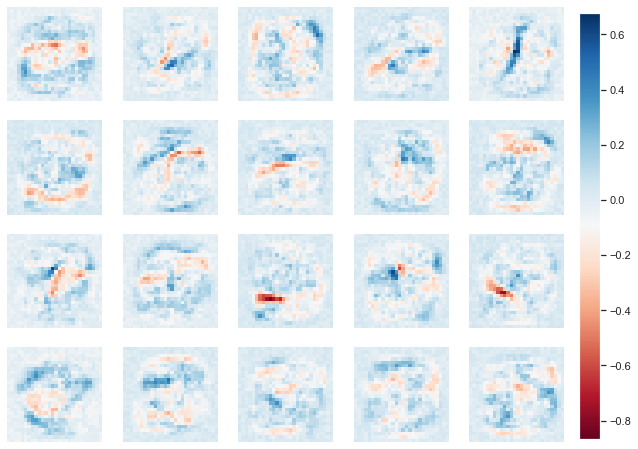

In [50]:
u5.plot_input_weights(model, input_shape=(28, 28))  # plot weights of the first nodes

What each node does is to compute a weighted sum of the input pixels, using the positive and negative weights depicted above. For a model without a hidden layer, these weighted sums directly correspond to the 10 digit classes, such that the largest weighted sum indicates the predicted digit. For a model with one or more hidden layers, they can be seen as <i>features</i> that the model extracts from the images and combines in later layers to distinguish digits. Some seem to resemble strokes. Feel free to add or remove layers from the model and see if the features change in appearance.